In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import jieba
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import torch
from torch_geometric.utils import from_networkx
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [44]:
with open('/content/drive/MyDrive/data mining/yearly_graphs_new/graph_1975.pkl', "rb") as f:
        G = pickle.load(f)

In [45]:
female_words = pd.read_csv('/content/drive/MyDrive/data mining/female_words.csv')
female_nodes = list(set(female_words['token'].tolist()))

In [46]:
for node in G.nodes:
    if node in female_nodes:
        G.nodes[node]['label'] = 1
    else:
        G.nodes[node]['label'] = 0

In [48]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


@torch.no_grad()
def plot_points(colors, save=False):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(2):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')

    if save:
        plt.savefig('node2vec.png')
    else:
        plt.show()

In [49]:
data = from_networkx(G)
data.y = torch.tensor([G.nodes[node]['label'] for node in G.nodes])
data.node_names = list(G.nodes)

num_nodes = data.num_nodes

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_size = int(0.8 * num_nodes)
train_indices = torch.randperm(num_nodes)[:train_size]
test_indices = torch.randperm(num_nodes)[train_size:]

data.train_mask[train_indices] = True
data.test_mask[test_indices] = True

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 9.1825, Acc: 0.8698
Epoch: 002, Loss: 7.5865, Acc: 0.8698
Epoch: 003, Loss: 6.1898, Acc: 0.8821
Epoch: 004, Loss: 5.0219, Acc: 0.9140
Epoch: 005, Loss: 4.1015, Acc: 0.9410
Epoch: 006, Loss: 3.4335, Acc: 0.9459
Epoch: 007, Loss: 2.9366, Acc: 0.9484
Epoch: 008, Loss: 2.5575, Acc: 0.9582
Epoch: 009, Loss: 2.2677, Acc: 0.9582
Epoch: 010, Loss: 2.0324, Acc: 0.9607
Epoch: 011, Loss: 1.8572, Acc: 0.9631
Epoch: 012, Loss: 1.7202, Acc: 0.9631
Epoch: 013, Loss: 1.6154, Acc: 0.9631
Epoch: 014, Loss: 1.5380, Acc: 0.9631
Epoch: 015, Loss: 1.4803, Acc: 0.9582
Epoch: 016, Loss: 1.4341, Acc: 0.9631
Epoch: 017, Loss: 1.3990, Acc: 0.9607
Epoch: 018, Loss: 1.3740, Acc: 0.9582
Epoch: 019, Loss: 1.3531, Acc: 0.9582
Epoch: 020, Loss: 1.3354, Acc: 0.9631
Epoch: 021, Loss: 1.3216, Acc: 0.9631
Epoch: 022, Loss: 1.3119, Acc: 0.9607
Epoch: 023, Loss: 1.3042, Acc: 0.9681
Epoch: 024, Loss: 1.2969, Acc: 0.9656
Epoch: 025, Loss: 1.2920, Acc: 0.9631
Epoch: 026, Loss: 1.2871, Acc: 0.9607
Epoch: 027, 

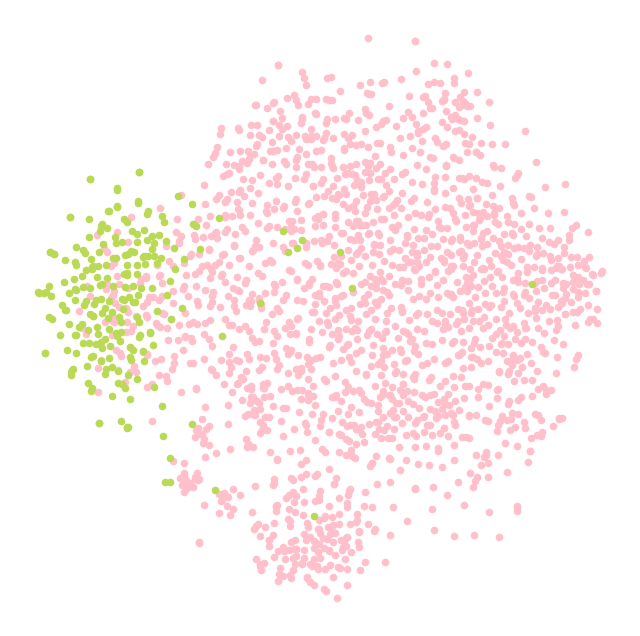

In [51]:
colors = ['#ffc0cb', '#bada55']
plot_points(colors)

In [52]:
model.eval()
embeddings = model().cpu()
data.embeddings = embeddings

In [ ]:
@torch.no_grad()
def plot_with_tsne_and_errors():
    embeddings = data.embeddings.cpu().numpy()
    labels = data.y.cpu().numpy()

    train_indices = data.train_mask.cpu().numpy().nonzero()[0]
    test_indices = data.test_mask.cpu().numpy().nonzero()[0]
    X_train, y_train = embeddings[train_indices], labels[train_indices]
    X_test, y_test = embeddings[test_indices], labels[test_indices]

    clf = LogisticRegression(max_iter=150, solver='lbfgs')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    error_mask = y_test != y_pred
    error_indices = test_indices[error_mask]
    error_words = [data.node_names[idx] for idx in error_indices]

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    num_classes = len(set(labels))
    colors = plt.cm.rainbow([i / num_classes for i in range(num_classes)])

    for label, color in zip(range(num_classes), colors):
        label_mask = (labels == label)
        plt.scatter(
            embeddings_2d[label_mask, 0],
            embeddings_2d[label_mask, 1],
            s=20,
            color=color,
            label=f"Class {label}"
        )

    for idx in error_indices:
        x, y = embeddings_2d[idx]
        plt.scatter(x, y, s=50, color='red', edgecolor='black', label="Misclassified" if 'Misclassified' not in plt.gca().get_legend_handles_labels()[1] else None)
        plt.annotate(data.node_names[idx], (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12)

    plt.legend()
    plt.axis("off")
    plt.show()

    print("Misclassified Words:", error_words)
    return error_words


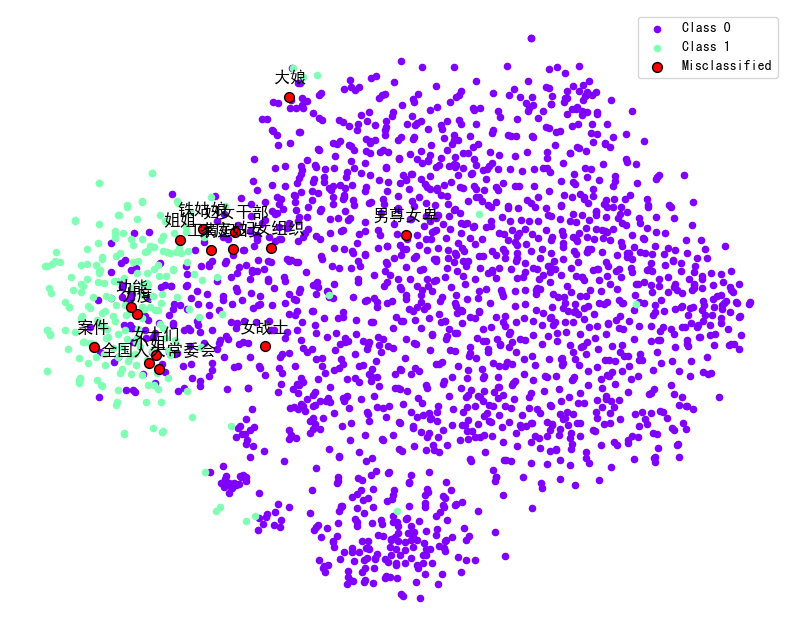

Misclassified Words: ['男尊女卑', '铁姑娘', '女士们', '大娘', '力度', '妇女干部', '功能', '家庭妇女', '姐姐', '妇女组织', '工青妇', '案件', '小姐', '女战士', '全国人大常委会']


In [60]:
error_words = plot_with_tsne_and_errors()